## Installs


In [312]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor as xgb

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.feature_selection import VarianceThreshold

%matplotlib inline

In [569]:
# For the linear model
def Linear_regression(features_train, features_test, target_train, target_test):
    # Before using our data, we need to do feature scaling and we opt for the 'standardization' method of scaling.
    # The 'standardization' is avaliable thorugh the StandardScaler() method
    # Transformers help in batching tasks in a pipepline. In this case, the data is scaled and then a linear regression model is fitted on the scaled data.
    # We use a transformer that takes the regression model and the transformation method
    # The TransformedTargetRegressor does the transformation and when we do the prediction, it automatically does the inverse transformation (scaling) and returns the values

    bool_cols = features_train.drop(columns=['was_home']).columns.tolist()
    categorical_cols = ['was_home']

    numerical_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('one_hot_encoder', OneHotEncoder())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, bool_cols),
            ('cat', categorical_transformer, categorical_cols),
        ])

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', LinearRegression())
    ])

    model = TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler())

    # TransformedTargetRegressor(
    #     LinearRegression(), transformer=StandardScaler())

    # fit the transofrmer on the train data
    model.fit(features_train, target_train)

    # With the model fitted, we can predict the total_points given the feature_train and feature_test set
    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)

    # Evaluate the performance of the model on both sets using the mean absolute error
    train_MAE = mean_absolute_error(target_train, pred_train)
    test_MAE = mean_absolute_error(target_test, pred_test)

    # Evaluate the performance of the model on both sets using the mean square error
    train_MSE = mean_squared_error(target_train, pred_train)
    test_MSE = mean_squared_error(target_test, pred_test)

    # Evaluate the performance of the model on both sets using the root mean square error
    train_RMSE = mean_squared_error(target_train, pred_train, squared=False)
    test_RMSE = mean_squared_error(target_test, pred_test, squared=False)

    # Get the score of the model or the coeeficient of determination i.e how much of the target value can be explained by the model.
    # In this case, 0.6 implies that 60% of the variations in the target value can be explained by the model and 40% is not explainable
    R2_train = model.score(features_train, target_train)
    R2_test = model.score(features_test, target_test)

    # If the test error significantly differs from the train error, then there is either overfitting or underfitting
    # RMSE, just like the squared loss function that it derives from, effectively penalizes larger errors more severely.
    print('Training set RMSE: {}'.format(train_RMSE))
    print('Test set RMSE: {}'.format(test_RMSE))

    print('Training set R2: {}'.format(R2_train))
    print('Test set R2: {}'.format(R2_test))

    # Carry out cross validation of the model.
    # The evaluation method is the root mean square error
    # The method expects a utility function (greater is better) and so the scoring function is the opposite of the the RMSE. Hence the -ve
    tree_rmses = -cross_val_score(model, features_train, target_train,
                                  scoring="neg_root_mean_squared_error", cv=10)

    return {'train_MAE': train_MAE, 'test_MAE': test_MAE, 'train_MSE': train_MSE, 'test_MSE': test_MSE, 'train_RMSE': train_RMSE, 'test_RMSE': test_RMSE, 'cv_rmse': tree_rmses.mean(), 'R2_train': R2_train, 'R2_test': R2_test}

# Decision Tree Model
def DecisionTreeRegression(features_train, features_test, target_train, target_test):
    # The DecisionTreeRegressor is passed as the model to the TransformedTreeRegressor together with the StandardScaler
    bool_cols = features_train.drop(columns=['was_home']).columns.tolist()
    categorical_cols = ['was_home']

    numerical_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('one_hot_encoder', OneHotEncoder())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, bool_cols),
            ('cat', categorical_transformer, categorical_cols),
        ])

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', DecisionTreeRegressor())
    ])

    model = TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler())
    # TransformedTargetRegressor(
    #     DecisionTreeRegressor(), transformer=StandardScaler())
    model.fit(features_train, target_train)

    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)

    train_MAE = mean_absolute_error(target_train, pred_train)
    test_MAE = mean_absolute_error(target_test, pred_test)

    train_MSE = mean_squared_error(target_train, pred_train)
    test_MSE = mean_squared_error(target_test, pred_test)

    train_RMSE = mean_squared_error(target_train, pred_train, squared=False)
    test_RMSE = mean_squared_error(target_test, pred_test, squared=False)

    R2_train = model.score(features_train, target_train)
    R2_test = model.score(features_test, target_test)

    tree_rmses = -cross_val_score(model, features_train, target_train,
                                  scoring="neg_root_mean_squared_error", cv=10)

    return {'train_MAE': train_MAE, 'test_MAE': test_MAE, 'train_MSE': train_MSE, 'test_MSE': test_MSE,
            'train_RMSE': train_RMSE, 'test_RMSE': test_RMSE, 'cv_rmse': tree_rmses.mean(), 'R2_train': R2_train, 'R2_test': R2_test}

# RandomForestRegressor
def RandomForestRegression(features_train, features_test, target_train, target_test, hyperparameters):
    # RandomForestRegressor is an ensemble method
    # The TransformedTargetRegressor is passed the RandomForestRegressor model
    # The RandomForestRegressor is passed some hyper-parameters such as;
    # n_esimtaors: number of trees in the forest,
    # max_depth: the maximum depth of the tree,
    # criterion: the function to measure the quality of the split

    model = TransformedTargetRegressor(RandomForestRegressor(
        n_estimators=hyperparameters['n_estimators'],  max_depth=hyperparameters['max_depth'], criterion=hyperparameters['criterion'], random_state=18), transformer=StandardScaler())
    model.fit(features_train, target_train)

    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)

    train_MAE = mean_absolute_error(target_train, pred_train)
    test_MAE = mean_absolute_error(target_test, pred_test)

    train_MSE = mean_squared_error(target_train, pred_train)
    test_MSE = mean_squared_error(target_test, pred_test)

    train_RMSE = mean_squared_error(target_train, pred_train, squared=False)
    test_RMSE = mean_squared_error(target_test, pred_test, squared=False)

    R2_train = model.score(features_train, target_train)
    R2_test = model.score(features_test, target_test)

    tree_rmses = -cross_val_score(model, features_train, target_train,
                                  scoring="neg_root_mean_squared_error", cv=10)

    return {'train_MAE': train_MAE, 'test_MAE': test_MAE, 'train_MSE': train_MSE, 'test_MSE': test_MSE,
            'train_RMSE': train_RMSE, 'test_RMSE': test_RMSE, 'cv_rmse': tree_rmses.mean(), 'R2_train': R2_train, 'R2_test': R2_test}

def XGBoostRegression(features_train, features_test, target_train, target_test, hyperparameters):
    regressor = xgb(learning_rate=hyperparameters["learning_rate"],
                    n_estimators=hyperparameters["n_estimators"],
                    max_depth=hyperparameters["max_depth"],
                    eval_metric='rmsle')

    model = TransformedTargetRegressor(regressor, transformer=StandardScaler())


    model.fit(features_train, target_train)

    # =========================================================================
    # To use early_stopping_rounds:
    # "Validation metric needs to improve at least once in every
    # early_stopping_rounds round(s) to continue training."
    # =========================================================================
    # first perform a test/train split
    # from sklearn.model_selection import train_test_split

    # X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size = 0.2)
    # model.fit(X_train, y_train, early_stopping_rounds=6, eval_set=[(X_test, y_test)], verbose=False)

    # =========================================================================
    # use the model to predict the prices for the test data
    # =========================================================================
    # predictions = model.predict(goalkeepers_splits['feature_test'])

    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)

    train_MAE = mean_absolute_error(target_train, pred_train)
    test_MAE = mean_absolute_error(target_test, pred_test)

    train_MSE = mean_squared_error(target_train, pred_train)
    test_MSE = mean_squared_error(target_test, pred_test)

    train_RMSE = mean_squared_error(target_train, pred_train, squared=False)
    test_RMSE = mean_squared_error(target_test, pred_test, squared=False)

    R2_train = model.score(features_train, target_train)
    R2_test = model.score(features_test, target_test)

    tree_rmses = -cross_val_score(model, features_train, target_train,
                                  scoring="neg_root_mean_squared_error", cv=10)

    return {'train_MAE': train_MAE, 'test_MAE': test_MAE, 'train_MSE': train_MSE, 'test_MSE': test_MSE,
            'train_RMSE': train_RMSE, 'test_RMSE': test_RMSE, 'cv_rmse': tree_rmses.mean(), 'R2_train': R2_train, 'R2_test': R2_test}

def GridSearchParams(features_train, target_train):
    # Instatiate the model
    model = RandomForestRegressor()

    param_grid = {'n_estimators': [8, 10, 12, 14, 16, 18, 20]}

    # Define the possible values of the hyperparameter
    grid = {
        'n_estimators': [8, 10, 12, 14, 16, 18, 20, 200, 300, 400, 500],
        'max_features': ['sqrt', 'log2'],
        'max_depth': [4, 5, 6, 7, 8],
        'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
        'random_state': [18]
    }

    # Deine the model with cv=3 for a 3-fold cross validation
    # GridSearchCV has the best_estimator_ parameter that returns the  estimator
    # which gave highest score (or smallest loss if specified)

    grid_search = GridSearchCV(
        model, grid, cv=3, scoring='neg_root_mean_squared_error')
    grid_search.fit(features_train, target_train)

    # Get the best param combination
    print(grid_search.best_estimator_)

    return {'train_RMSE': train_RMSE, 'test_RMSE': test_RMSE, 'R2_train': R2_train, 'R2_test': R2_test}

## Get Data


In [ ]:
data_22_23 = pd.read_csv('./data/joint/22-23/merged_player_data.csv').dropna()
data_23_24 = pd.read_csv('./data/joint/23-24/merged_player_data.csv').dropna()
data_24_25 = pd.read_csv('./data/joint/24-25/merged_player_data.csv').dropna()
data_tar = data_24_25[data_24_25['event']==10]
data_24_25 = data_24_25[data_24_25['event'] != 10]

data = pd.concat([data_22_23, data_23_24, data_24_25])
predicted = pd.DataFrame()

data_225 = data[(data['minutes_5'] >= 300) & (data['position'] != 'GK')]
data_tar_225 = data_tar[(data_tar['minutes_5'] >= 300) & (data_tar['position'] != 'GK')]

In [ ]:

data_225 = data[(data['minutes_5'] >= 300) & (data['position'] != 'GK')]
data_tar_225 = data_tar[(data_tar['minutes_5'] >= 300) & (data_tar['position'] != 'GK')]
players = data_225 #.drop('position', axis=1) #  & (data['position'] == 'FWD')
# players

## Expected Goals


In [557]:
# - Include Bookmarker odds
# - xG90 last 5 full matches
# - G90 last 5 full matches
# - Position
# - was home
# - FDR
# -----------------------------------------
# - Exclude Gks
# - Start with Gw 6
# - Only those who played 90 minutes are included
#

In [558]:

xg_data= data[(data['minutes_5'] >= 300) & (data['position'] != 'GK')][['position', 'minutes_3', 'minutes_5', 'team_h_difficulty', 'team_a_difficulty', 'ict_index_3',  'ict_index_5',
                                                                     'influence_3', 'influence_5', 'creativity_3', 'creativity_5', 'threat_3', 'threat_5', 'was_home', 'xG', 'xG_3',
                                                                      'xG_5', 'expected_goals_3', 'expected_goals_5', 'expected_goals_5',  'goals_scored_3',  'goals_scored_3',
                                                                       'whh', 'whd', 'wha']]

xg_data_tar = data_tar[(data_tar['minutes_5'] >= 300) & (data_tar['position'] != 'GK')][['position', 'minutes_3', 'minutes_5', 'team_h_difficulty', 'team_a_difficulty', 'ict_index_3',  'ict_index_5',
                                                                     'influence_3', 'influence_5', 'creativity_3', 'creativity_5', 'threat_3', 'threat_5', 'was_home', 'xG', 'xG_3',
                                                                      'xG_5', 'expected_goals_3', 'expected_goals_5', 'expected_goals_5',  'goals_scored_3',  'goals_scored_3',
                                                                       'whh', 'whd', 'wha']]
# players = data_225 #.drop('position', axis=1) #  & (data['position'] == 'FWD')
# # players


In [559]:
enc =  pd.get_dummies(xg_data, columns=['position', 'was_home'])
enc_tar = pd.get_dummies(xg_data_tar, columns=['position', 'was_home'])
enc_tar_y = enc_tar['xG']
enc_tar_X = enc_tar.drop('xG', axis=1)

In [560]:

xg = enc[['xG']]
feats = enc.drop('xG', axis=1)
feats_train, feats_test, xg_train, xg_test = train_test_split(feats, xg , test_size=0.2, random_state=42)

In [561]:
model = LinearRegression()

model.fit(feats_train, xg_train)

pred_train = model.predict(feats_train)
pred_test = model.predict(feats_test)


In [562]:
'rmse: ', mean_squared_error(xg_train, pred_train, squared=False), mean_squared_error(xg_test, pred_test, squared=False), 'mse: ', mean_squared_error(xg_train, pred_train), mean_squared_error(xg_test, pred_test), 'mae: ', mean_absolute_error(xg_train, pred_train), mean_absolute_error(xg_test, pred_test), 'score: ', model.score(feats_train, xg_train), model.score(feats_test, xg_test)

('rmse: ',
 0.24533499425130184,
 0.23700689247352374,
 'mse: ',
 0.0601892594042863,
 0.05617226707995645,
 'mae: ',
 0.14625943186431756,
 0.15036305902960004,
 'score: ',
 0.21674500347474746,
 0.20991350135724285)

In [563]:
tree_rmses = -cross_val_score(model, feats_train, xg_train, scoring="neg_root_mean_squared_error", cv=10)
tree_rmses

array([0.26193077, 0.24838457, 0.23259254, 0.2612569 , 0.22964514,
       0.24485744, 0.25187926, 0.25880532, 0.24826986, 0.22849346])

In [564]:
pred = model.predict(enc_tar_X)
enc_tar['xG_pred'] = pred

<Axes: >

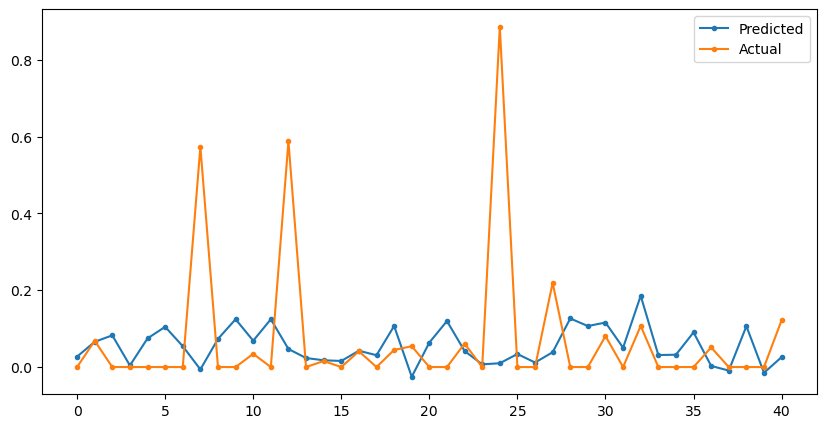

In [568]:
df = pd.DataFrame(list(zip(enc_tar[enc_tar['position_DEF']==1]['xG_pred'] , enc_tar[enc_tar['position_DEF']==1]['xG'] )),
                #   index = subjects ,
                  columns = [ 'Predicted' , 'Actual' ])

df.plot(style='.-', figsize=(10, 5))

## Expected Assists


In [458]:
# - Include Bookmarker odds
# - xG90 last 5 full matches
# - G90 last 5 full matches
# - Position
# - was home
# - FDR
# -----------------------------------------
# - Exclude Gks
# - Start with Gw 6
# - Only those who played 90 minutes are included
#

In [459]:
data['xA']

0       0.071387
1       0.290993
2       0.175495
3       0.000000
4       0.000000
          ...   
2316    0.104299
2317    0.000000
2318    0.000000
2319    0.048280
2320    0.000000
Name: xA, Length: 21306, dtype: float64

In [ ]:

xa_data= data[(data['minutes_5'] >= 300) & (data['position'] != 'GK')][['position', 'minutes_3', 'minutes_5', 'team_h_difficulty', 'team_a_difficulty', 'ict_index_3',  'ict_index_5', 'influence_3', 'influence_5', 'creativity_3', 'creativity_5',
                                                                         'threat_3', 'threat_5', 'was_home', 'expected_assists', 'xA_3', 'xA_5',  'expected_assists_3', 'expected_assists_5', 'whh', 'whd', 'wha']]

xa_data_tar = data_tar[(data_tar['minutes_5'] >= 300) & (data_tar['position'] != 'GK')][['position', 'minutes_3', 'minutes_5', 'team_h_difficulty', 'team_a_difficulty', 'ict_index_3',  'ict_index_5', 'influence_3', 'influence_5', 'creativity_3', 'creativity_5',
                                                                         'threat_3', 'threat_5','was_home', 'expected_assists', 'xA_3', 'xA_5',  'expected_assists_3',
                    'expected_assists_5', 'whh', 'whd', 'wha']]
players = data_225 #.drop('position', axis=1) #  & (data['position'] == 'FWD')
# players


In [461]:
enc =  pd.get_dummies(xa_data, columns=['position', 'was_home'])
enc_tar = pd.get_dummies(xa_data_tar, columns=['position', 'was_home'])
enc_tar_y = enc_tar['expected_assists']
enc_tar_X = enc_tar.drop('expected_assists', axis=1)

In [462]:

xa = enc[['expected_assists']]
feats = enc.drop('expected_assists', axis=1)
feats_train, feats_test, xa_train, xa_test = train_test_split(feats, xa , test_size=0.2, random_state=42)

In [463]:
model = LinearRegression()

model.fit(feats_train, xa_train)

pred_train = model.predict(feats_train)
pred_test = model.predict(feats_test)


In [464]:
'rmse: ', mean_squared_error(xa_train, pred_train, squared=False), mean_squared_error(xa_test, pred_test, squared=False), 'mse: ', mean_squared_error(xa_train, pred_train), mean_squared_error(xa_test, pred_test), 'mae: ', mean_absolute_error(xa_train, pred_train), mean_absolute_error(xa_test, pred_test), 'score: ', model.score(feats_train, xa_train), model.score(feats_test, xa_test)

('rmse: ',
 0.12634104761469664,
 0.1462275946611744,
 'mse: ',
 0.015962060312379043,
 0.02138250944039272,
 'mae: ',
 0.07895854168901975,
 0.08605006339881278,
 'score: ',
 0.1622015124341647,
 0.17097700889736522)

In [465]:
tree_rmses = -cross_val_score(model, feats_train, xa_train, scoring="neg_root_mean_squared_error", cv=10)
tree_rmses

array([0.11700927, 0.11977294, 0.13102782, 0.1253399 , 0.12760683,
       0.13829142, 0.12002636, 0.14238143, 0.12378398, 0.12140339])

In [466]:
enc_tar

,minutes_3,minutes_5,team_h_difficulty,team_a_difficulty,ict_index_3,ict_index_5,influence_3,influence_5,creativity_3,creativity_5,...,expected_assists_3,expected_assists_5,whh,whd,wha,position_DEF,position_FWD,position_MID,was_home_False,was_home_True
21,270.0,450.0,2,2,11.4,21.8,60.2,97.2,30.7,83.7,...,0.15,0.50,0.47,0.29,0.29,1,0,0,1,0
70,224.0,365.0,2,3,15.6,26.4,27.2,57.4,67.7,113.8,...,0.41,1.05,0.49,0.27,0.29,0,0,1,0,1
81,270.0,450.0,4,3,26.8,35.7,68.4,79.4,53.3,76.0,...,0.10,0.18,0.38,0.26,0.40,0,0,1,0,1
92,256.0,436.0,2,3,16.4,36.1,73.4,123.4,52.8,140.9,...,0.71,1.08,0.49,0.27,0.29,0,0,1,0,1
111,229.0,357.0,2,2,10.3,11.8,48.2,59.0,44.7,46.8,...,0.20,0.21,0.47,0.29,0.29,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2223,254.0,434.0,2,3,16.4,19.8,70.2,93.6,69.6,77.7,...,0.49,0.53,0.49,0.27,0.29,0,0,1,1,0
2238,180.0,326.0,4,3,5.4,8.7,47.6,67.4,4.2,15.0,...,0.03,0.03,0.38,0.26,0.40,1,0,0,1,0
2249,253.0,433.0,2,2,8.0,20.5,45.6,114.6,16.7,40.8,...,0.07,0.13,0.44,0.28,0.32,0,0,1,1,0
2285,270.0,450.0,2,2,9.2,14.7,65.6,113.2,16.2,17.7,...,0.07,0.13,0.44,0.28,0.32,1,0,0,1,0


In [467]:
pred = model.predict(enc_tar_X)
enc_tar['xA_pred'] = pred

In [468]:
enc_tar.columns #[enc_tar['position']== 'GK']

Index(['minutes_3', 'minutes_5', 'team_h_difficulty', 'team_a_difficulty',
       'ict_index_3', 'ict_index_5', 'influence_3', 'influence_5',
       'creativity_3', 'creativity_5', 'threat_3', 'threat_5',
       'expected_assists', 'xA_3', 'xA_5', 'expected_assists_3',
       'expected_assists_5', 'whh', 'whd', 'wha', 'position_DEF',
       'position_FWD', 'position_MID', 'was_home_False', 'was_home_True',
       'xA_pred'],
      dtype='object')

<Axes: >

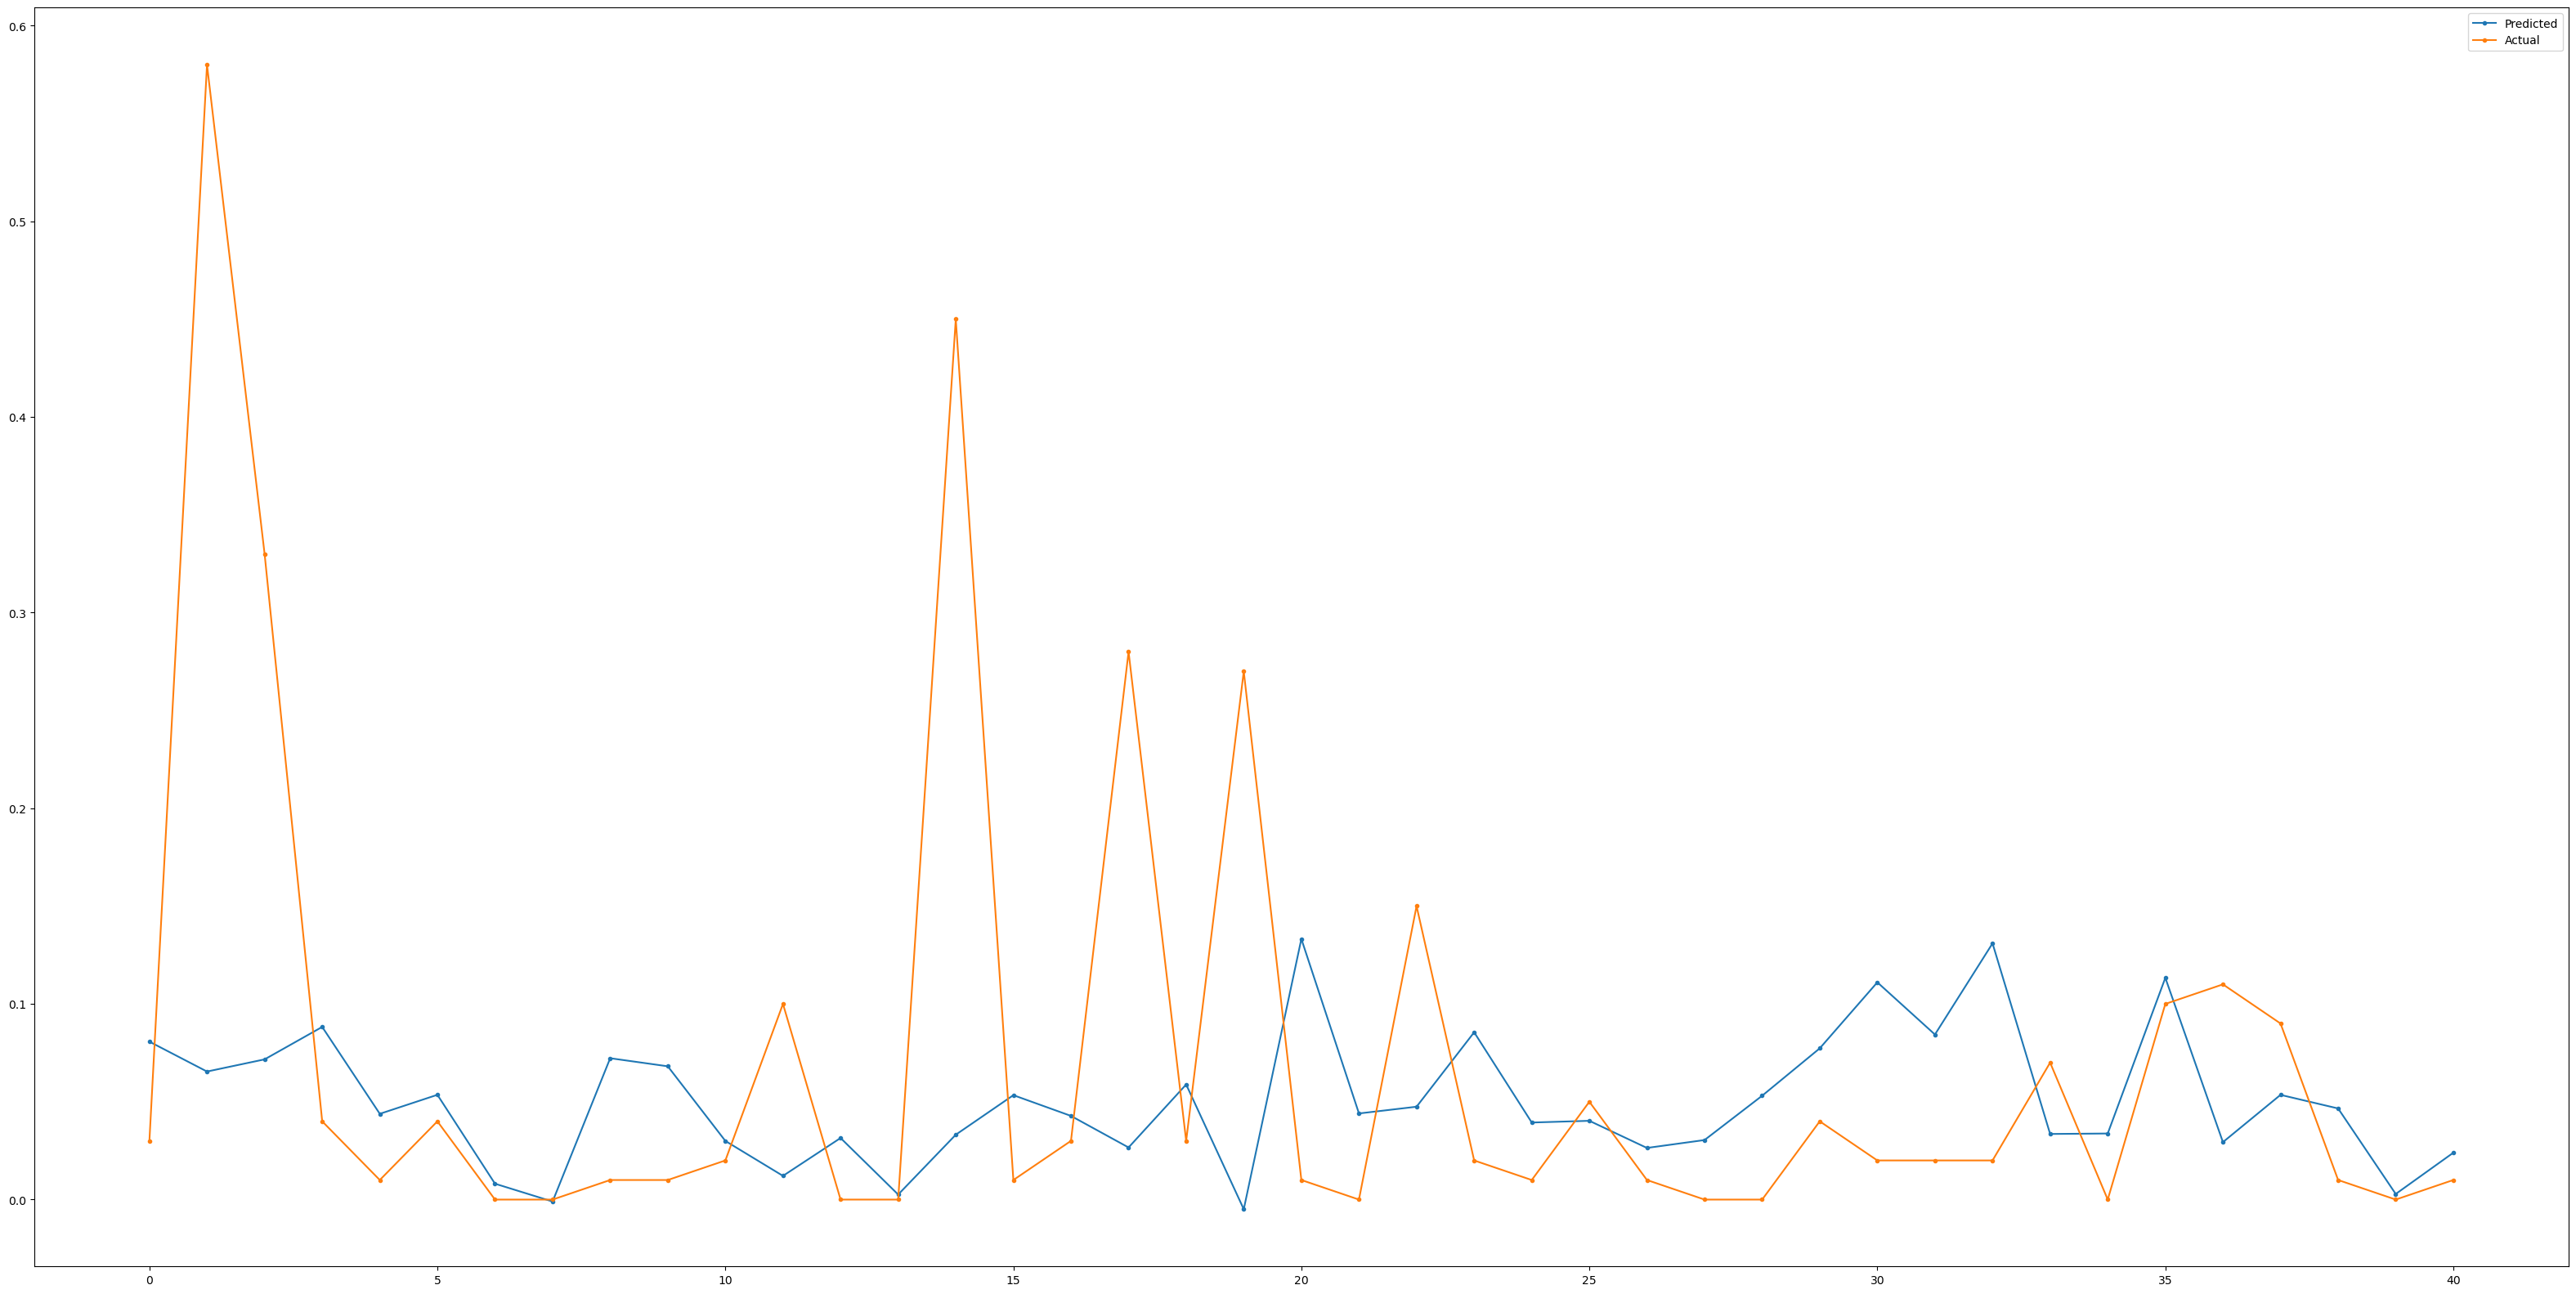

In [469]:
df = pd.DataFrame(list(zip(enc_tar[enc_tar['position_DEF']==1]['xA_pred'] , enc_tar[enc_tar['position_DEF']==1]['expected_assists'] )),
                #   index = subjects ,
                  columns = [ 'Predicted' , 'Actual' ])

df.plot(style='.-', figsize=(40, 20))

## Cleansheets


In [434]:
# - Include Bookmarker odds
# - xG90 last 5 full matches
# - G90 last 5 full matches
# - Position
# - was home
# - FDR
# -----------------------------------------
# - Exclude Gks
# - Start with Gw 6
# - Only those who played 90 minutes are included
#

In [ ]:
#
cs_data= data[(data['minutes_5'] >= 300) & (data['position'] != 'FWD')][['position', 'minutes_3', 'minutes_5', 'team_h_difficulty', 'team_a_difficulty', 'was_home', 'clean_sheets', 'clean_sheets_3', 'clean_sheets_5',
                                                                         'expected_goals_conceded_3', 'expected_goals_conceded_5', 'ict_index_3',  'ict_index_5', 'influence_3', 'influence_5', 'creativity_3', 'creativity_5',
                                                                         'threat_3', 'threat_5', 'whh', 'whd', 'wha']]

cs_data_tar = data_tar[(data_tar['minutes_5'] >= 300) & (data_tar['position'] != 'FWD')][['position', 'minutes_3', 'minutes_5', 'team_h_difficulty', 'team_a_difficulty', 'was_home', 'clean_sheets', 'clean_sheets_3', 'clean_sheets_5',
                                                                         'expected_goals_conceded_3', 'expected_goals_conceded_5', 'ict_index_3',  'ict_index_5', 'influence_3', 'influence_5', 'creativity_3', 'creativity_5',
                                                                         'threat_3', 'threat_5', 'whh', 'whd', 'wha']]
# players = data_225 #.drop('position', axis=1) #  & (data['position'] == 'FWD')
# # players


In [436]:
enc =  pd.get_dummies(cs_data, columns=['position', 'was_home'])
enc_tar = pd.get_dummies(cs_data_tar, columns=['position', 'was_home'])
enc_tar_y = enc_tar['clean_sheets']
enc_tar_X = enc_tar.drop('clean_sheets', axis=1)

In [437]:

cs = enc[['clean_sheets']]
feats = enc.drop('clean_sheets', axis=1)
feats_train, feats_test, cs_train, cs_test = train_test_split(feats, cs , test_size=0.2, random_state=42)

In [438]:
model = LinearRegression()

model.fit(feats_train, cs_train)

pred_train = model.predict(feats_train)
pred_test = model.predict(feats_test)


In [439]:
'rmse: ', mean_squared_error(cs_train, pred_train, squared=False), mean_squared_error(cs_test, pred_test, squared=False), 'mse: ', mean_squared_error(cs_train, pred_train), mean_squared_error(cs_test, pred_test), 'mae: ', mean_absolute_error(cs_train, pred_train), mean_absolute_error(cs_test, pred_test), 'score: ', model.score(feats_train, cs_train), model.score(feats_test, cs_test)

('rmse: ',
 0.4233363942131232,
 0.43171209882403033,
 'mse: ',
 0.17921370266536885,
 0.18637533627104932,
 'mae: ',
 0.3584406704209359,
 0.3649528032064879,
 'score: ',
 0.028331938844663895,
 0.026594031758269465)

In [440]:
tree_rmses = -cross_val_score(model, feats_train, cs_train, scoring="neg_root_mean_squared_error", cv=10)
tree_rmses

array([0.4241304 , 0.40055504, 0.42161029, 0.42256092, 0.42267611,
       0.42547755, 0.42973813, 0.44219926, 0.41054231, 0.44721491])

In [441]:
enc_tar

,minutes_3,minutes_5,team_h_difficulty,team_a_difficulty,clean_sheets,clean_sheets_3,clean_sheets_5,expected_goals_conceded_3,expected_goals_conceded_5,ict_index_3,...,threat_3,threat_5,whh,whd,wha,position_DEF,position_GK,position_MID,was_home_False,was_home_True
11,270.0,450.0,2,2,1,0.0,0.0,8.99,12.06,7.8,...,0.0,0.0,0.38,0.29,0.38,0,1,0,0,1
21,270.0,450.0,2,2,0,0.0,0.0,4.69,7.25,11.4,...,23.0,37.0,0.47,0.29,0.29,1,0,0,1,0
70,224.0,365.0,2,3,0,1.0,2.0,3.42,5.29,15.6,...,61.0,93.0,0.49,0.27,0.29,0,0,1,0,1
81,270.0,450.0,4,3,0,1.0,2.0,4.13,9.73,26.8,...,148.0,204.0,0.38,0.26,0.40,0,0,1,0,1
92,256.0,436.0,2,3,0,1.0,2.0,3.43,5.77,16.4,...,38.0,97.0,0.49,0.27,0.29,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2223,254.0,434.0,2,3,0,0.0,0.0,3.49,8.00,16.4,...,24.0,26.0,0.49,0.27,0.29,0,0,1,1,0
2238,180.0,326.0,4,3,0,0.0,0.0,2.77,4.38,5.4,...,2.0,4.0,0.38,0.26,0.40,1,0,0,1,0
2249,253.0,433.0,2,2,0,1.0,1.0,5.86,10.66,8.0,...,18.0,50.0,0.44,0.28,0.32,0,0,1,1,0
2285,270.0,450.0,2,2,0,1.0,1.0,6.04,11.74,9.2,...,10.0,16.0,0.44,0.28,0.32,1,0,0,1,0


In [442]:
pred = model.predict(enc_tar_X)
enc_tar['cs_pred'] = pred

In [443]:
enc_tar.columns #[enc_tar['position']== 'GK']

Index(['minutes_3', 'minutes_5', 'team_h_difficulty', 'team_a_difficulty',
       'clean_sheets', 'clean_sheets_3', 'clean_sheets_5',
       'expected_goals_conceded_3', 'expected_goals_conceded_5', 'ict_index_3',
       'ict_index_5', 'influence_3', 'influence_5', 'creativity_3',
       'creativity_5', 'threat_3', 'threat_5', 'whh', 'whd', 'wha',
       'position_DEF', 'position_GK', 'position_MID', 'was_home_False',
       'was_home_True', 'cs_pred'],
      dtype='object')

<Axes: >

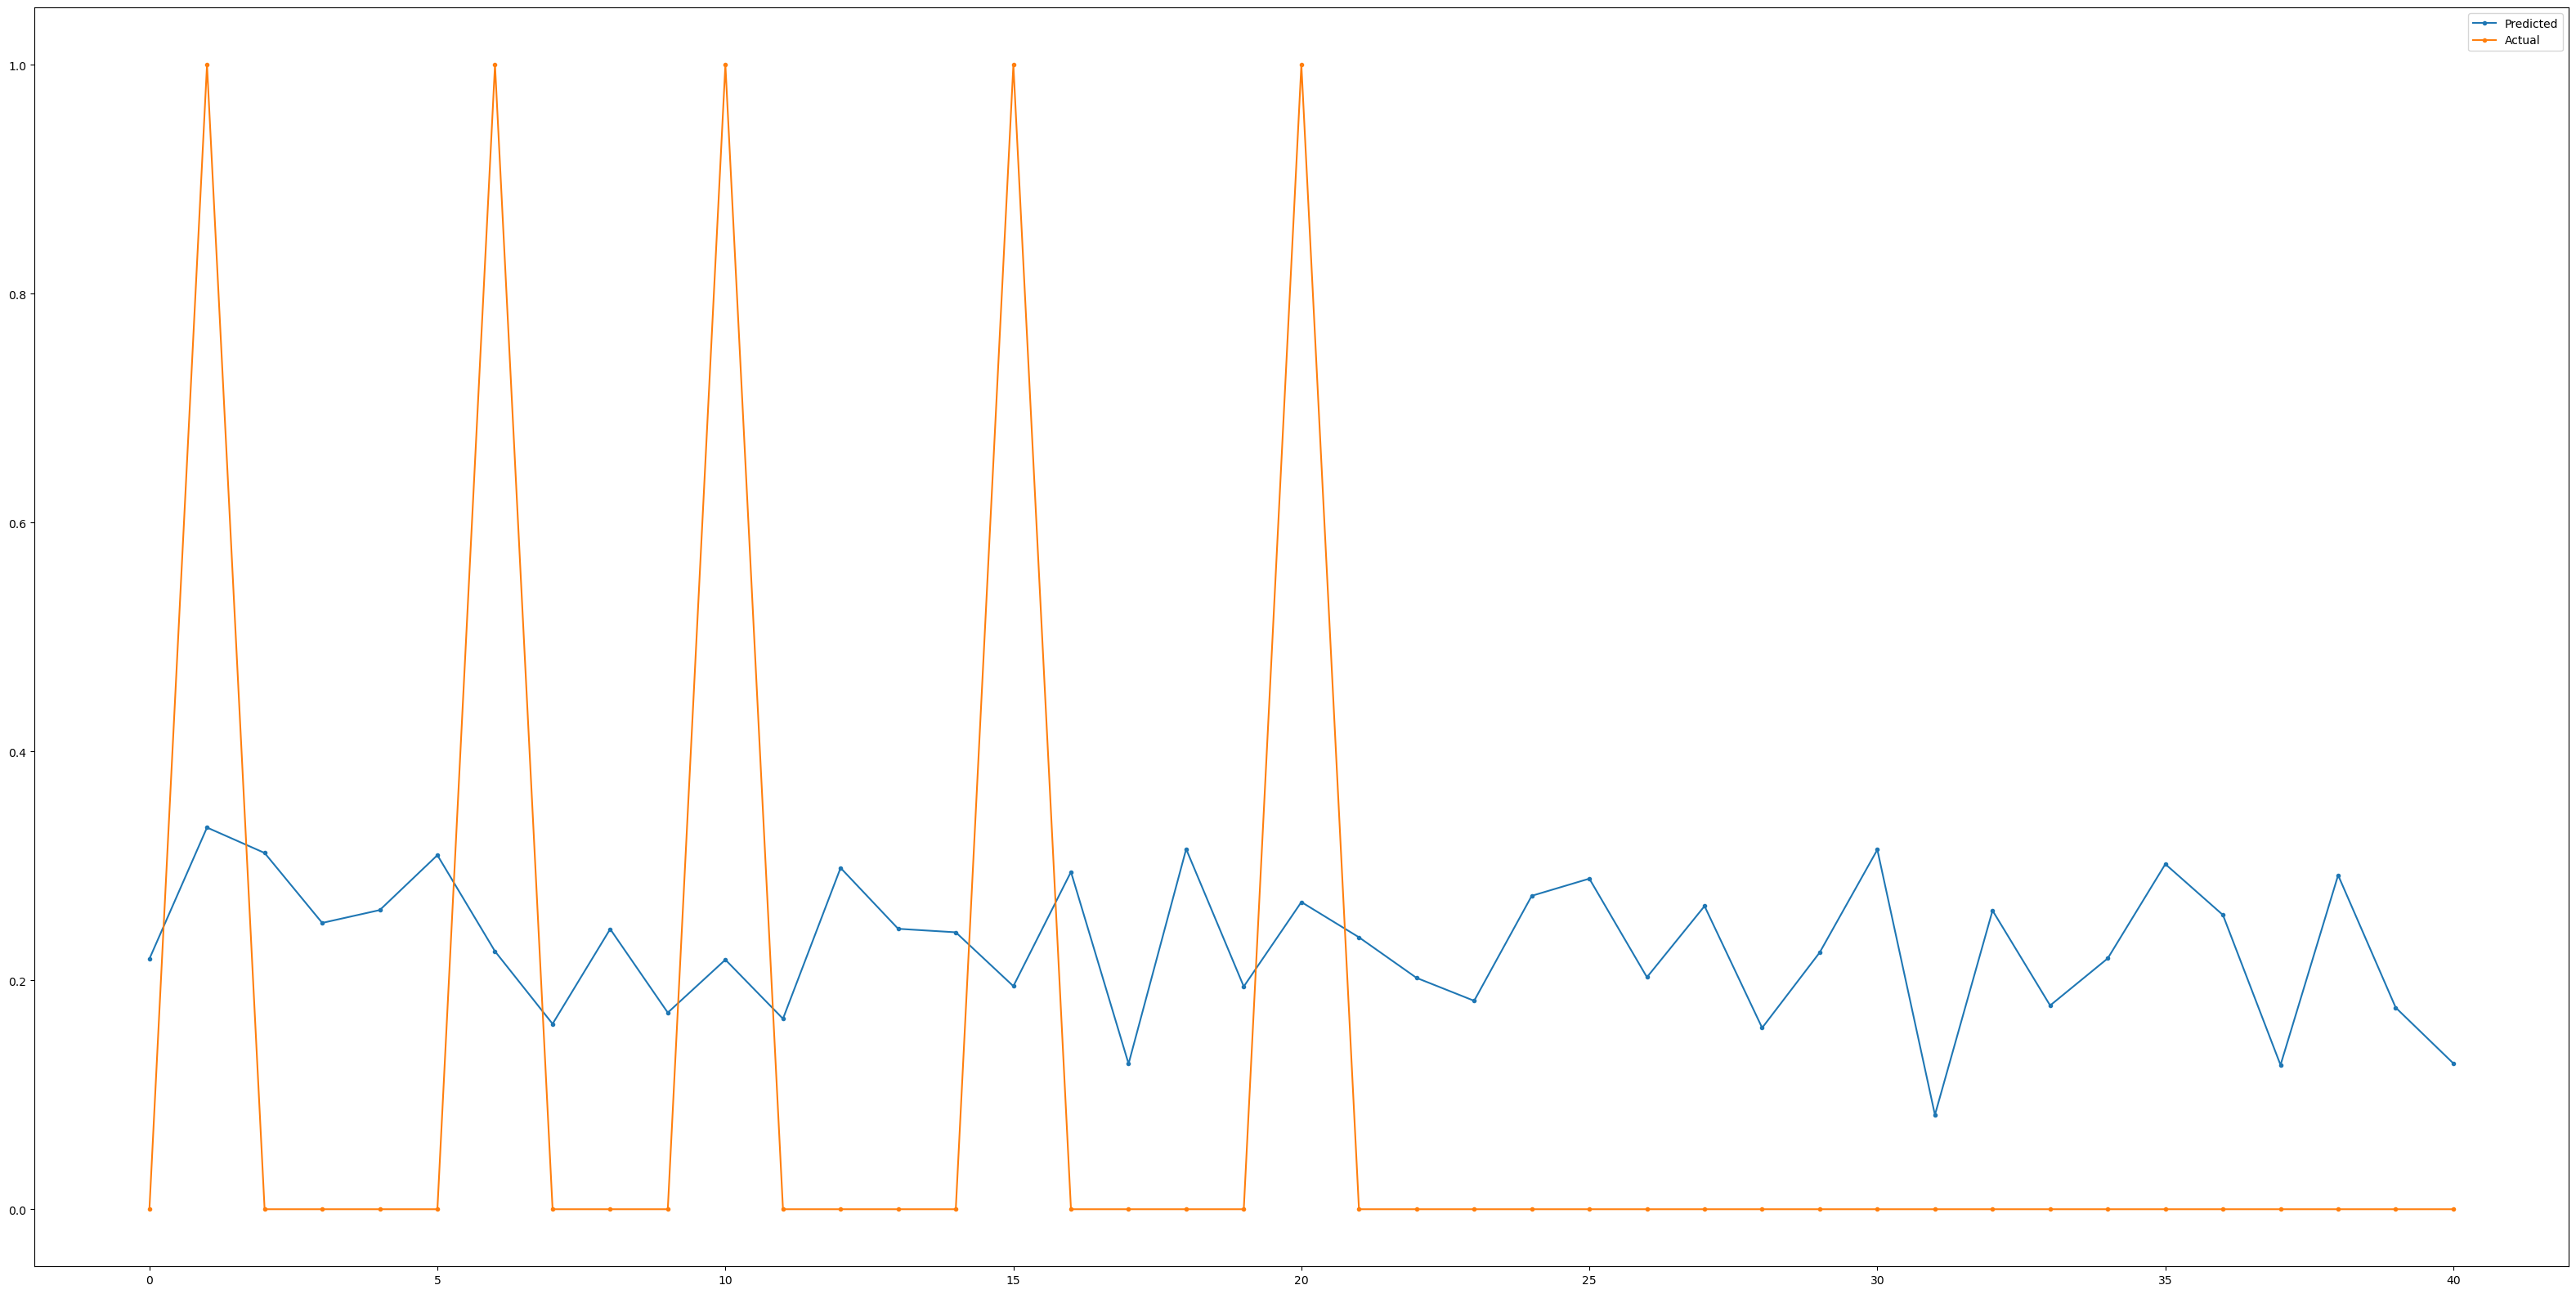

In [444]:
df = pd.DataFrame(list(zip(enc_tar[enc_tar['position_DEF']==1]['cs_pred'] , enc_tar[enc_tar['position_DEF']==1]['clean_sheets'] )),
                #   index = subjects ,
                  columns = [ 'Predicted' , 'Actual' ])

df.plot(style='.-', figsize=(40, 20))

## Saves


In [506]:
# - Include Bookmarker odds
# - xG90 last 5 full matches
# - G90 last 5 full matches
# - Position
# - was home
# - FDR
# -----------------------------------------
# - Exclude Gks
# - Start with Gw 6
# - Only those who played 90 minutes are included
#

In [ ]:
#
sv_data= data[(data['minutes_5'] >= 300) & (data['position'] == 'GK')][['position', 'minutes_3', 'minutes_5', 'team_h_difficulty', 'team_a_difficulty', 'was_home', 'ict_index_3',
                                                                         'ict_index_5', 'influence_3', 'influence_5', 'creativity_3', 'creativity_5', 'threat_3', 'threat_5', 'saves',
                                                                          'saves_3', 'saves_5', 'whh', 'whd', 'wha']]

sv_data_tar = data_tar[(data_tar['minutes_5'] >= 300) & (data_tar['position'] == 'GK')][['position', 'minutes_3', 'minutes_5', 'team_h_difficulty', 'team_a_difficulty', 'was_home', 'ict_index_3',
                                                                         'ict_index_5', 'influence_3', 'influence_5', 'creativity_3', 'creativity_5', 'threat_3', 'threat_5', 'saves',
                                                                          'saves_3', 'saves_5', 'whh', 'whd', 'wha']]

# players = data_225 #.drop('position', axis=1) #  & (data['position'] == 'FWD')
# # players


In [508]:
enc =  pd.get_dummies(sv_data, columns=['position', 'was_home'])
enc_tar = pd.get_dummies(sv_data_tar, columns=['position', 'was_home'])
enc_tar_y = enc_tar['saves']
enc_tar_X = enc_tar.drop('saves', axis=1)

In [509]:

sv = enc[['saves']]
feats = enc.drop('saves', axis=1)
feats_train, feats_test, sv_train, sv_test = train_test_split(feats, sv , test_size=0.2, random_state=42)

In [510]:
model = LinearRegression()

model.fit(feats_train, sv_train)

pred_train = model.predict(feats_train)
pred_test = model.predict(feats_test)


In [511]:
'rmse: ', mean_squared_error(sv_train, pred_train, squared=False), mean_squared_error(sv_test, pred_test, squared=False), 'mse: ', mean_squared_error(sv_train, pred_train), mean_squared_error(sv_test, pred_test), 'mae: ', mean_absolute_error(sv_train, pred_train), mean_absolute_error(sv_test, pred_test), 'score: ', model.score(feats_train, sv_train), model.score(feats_test, sv_test)

('rmse: ',
 1.894987259516022,
 2.0674381250780685,
 'mse: ',
 3.5909767137280433,
 4.27430040102632,
 'mae: ',
 1.5226744308294704,
 1.562041628561404,
 'score: ',
 0.06940419631398054,
 -0.01717691081656869)

In [512]:
tree_rmses = -cross_val_score(model, feats_train, sv_train, scoring="neg_root_mean_squared_error", cv=10)
tree_rmses

array([1.700838  , 2.39341887, 1.989491  , 1.66181743, 2.4721227 ,
       1.52012221, 1.9468389 , 1.91394819, 1.83783967, 1.91766416])

In [513]:
enc

,minutes_3,minutes_5,team_h_difficulty,team_a_difficulty,ict_index_3,ict_index_5,influence_3,influence_5,creativity_3,creativity_5,...,threat_5,saves,saves_3,saves_5,whh,whd,wha,position_GK,was_home_False,was_home_True
58,270.0,360.0,2,4,3.9,5.8,38.0,57.0,0.0,0.0,...,0.0,2,4.0,6.0,0.69,0.23,0.14,1,0,1
59,270.0,450.0,4,4,4.4,7.5,43.8,74.4,0.0,0.0,...,0.0,3,5.0,8.0,0.40,0.29,0.37,1,1,0
60,180.0,360.0,4,3,4.2,6.9,42.6,69.0,0.0,0.0,...,0.0,2,5.0,8.0,0.24,0.26,0.56,1,1,0
61,180.0,360.0,3,4,4.3,7.9,43.0,79.2,0.0,0.0,...,0.0,2,5.0,9.0,0.49,0.29,0.29,1,0,1
62,180.0,360.0,4,4,3.7,7.9,37.0,79.6,0.0,0.0,...,0.0,2,4.0,9.0,0.40,0.28,0.38,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,270.0,450.0,2,4,13.4,17.2,134.8,173.2,0.0,0.0,...,0.0,4,16.0,21.0,0.57,0.24,0.23,1,0,1
1965,270.0,450.0,3,4,13.5,16.6,135.2,166.6,0.0,0.0,...,0.0,8,18.0,22.0,0.67,0.22,0.15,1,0,1
1966,270.0,450.0,4,5,12.5,20.7,125.4,208.0,0.0,0.0,...,0.0,3,19.0,28.0,0.61,0.23,0.21,1,1,0
1967,270.0,450.0,3,4,10.0,21.8,100.0,218.4,0.0,0.0,...,0.0,1,15.0,29.0,0.56,0.24,0.25,1,0,1


In [514]:
pred = model.predict(enc_tar_X)
enc_tar['sv_pred'] = pred

In [515]:
enc_tar.columns #[enc_tar['position']== 'GK']

Index(['minutes_3', 'minutes_5', 'team_h_difficulty', 'team_a_difficulty',
       'ict_index_3', 'ict_index_5', 'influence_3', 'influence_5',
       'creativity_3', 'creativity_5', 'threat_3', 'threat_5', 'saves',
       'saves_3', 'saves_5', 'whh', 'whd', 'wha', 'position_GK',
       'was_home_False', 'was_home_True', 'sv_pred'],
      dtype='object')

In [518]:
enc_tar

,minutes_3,minutes_5,team_h_difficulty,team_a_difficulty,ict_index_3,ict_index_5,influence_3,influence_5,creativity_3,creativity_5,...,saves,saves_3,saves_5,whh,whd,wha,position_GK,was_home_False,was_home_True,sv_pred
11,270.0,450.0,2,2,7.8,14.2,78.0,142.0,0.0,0.0,...,5,10.0,18.0,0.38,0.29,0.38,1,0,1,2.772480
262,270.0,450.0,2,3,12.6,16.0,116.2,150.4,10.0,10.0,...,1,12.0,17.0,0.49,0.27,0.29,1,0,1,3.179181
531,270.0,450.0,5,4,4.0,11.4,39.4,113.2,0.0,0.0,...,3,5.0,15.0,0.27,0.28,0.50,1,1,0,3.278367
542,270.0,450.0,2,2,7.1,13.1,71.0,127.2,0.0,0.0,...,4,11.0,18.0,0.40,0.29,0.36,1,1,0,1.915869
635,270.0,450.0,5,3,4.7,8.0,47.4,80.8,0.0,0.0,...,4,5.0,9.0,0.18,0.23,0.62,1,1,0,2.790180
675,270.0,450.0,3,4,9.4,14.5,93.8,144.6,0.0,0.0,...,2,9.0,15.0,0.52,0.25,0.27,1,1,0,3.281177
1212,270.0,450.0,2,2,8.3,11.6,83.4,116.6,0.0,0.0,...,1,7.0,11.0,0.38,0.29,0.38,1,1,0,2.856347
1775,270.0,450.0,5,4,8.0,16.8,80.8,169.2,0.0,0.0,...,0,11.0,24.0,0.27,0.28,0.50,1,0,1,3.631781
1968,270.0,450.0,4,3,9.6,16.5,96.0,165.0,0.0,0.0,...,3,12.0,23.0,0.38,0.26,0.40,1,1,0,3.813066


<Axes: >

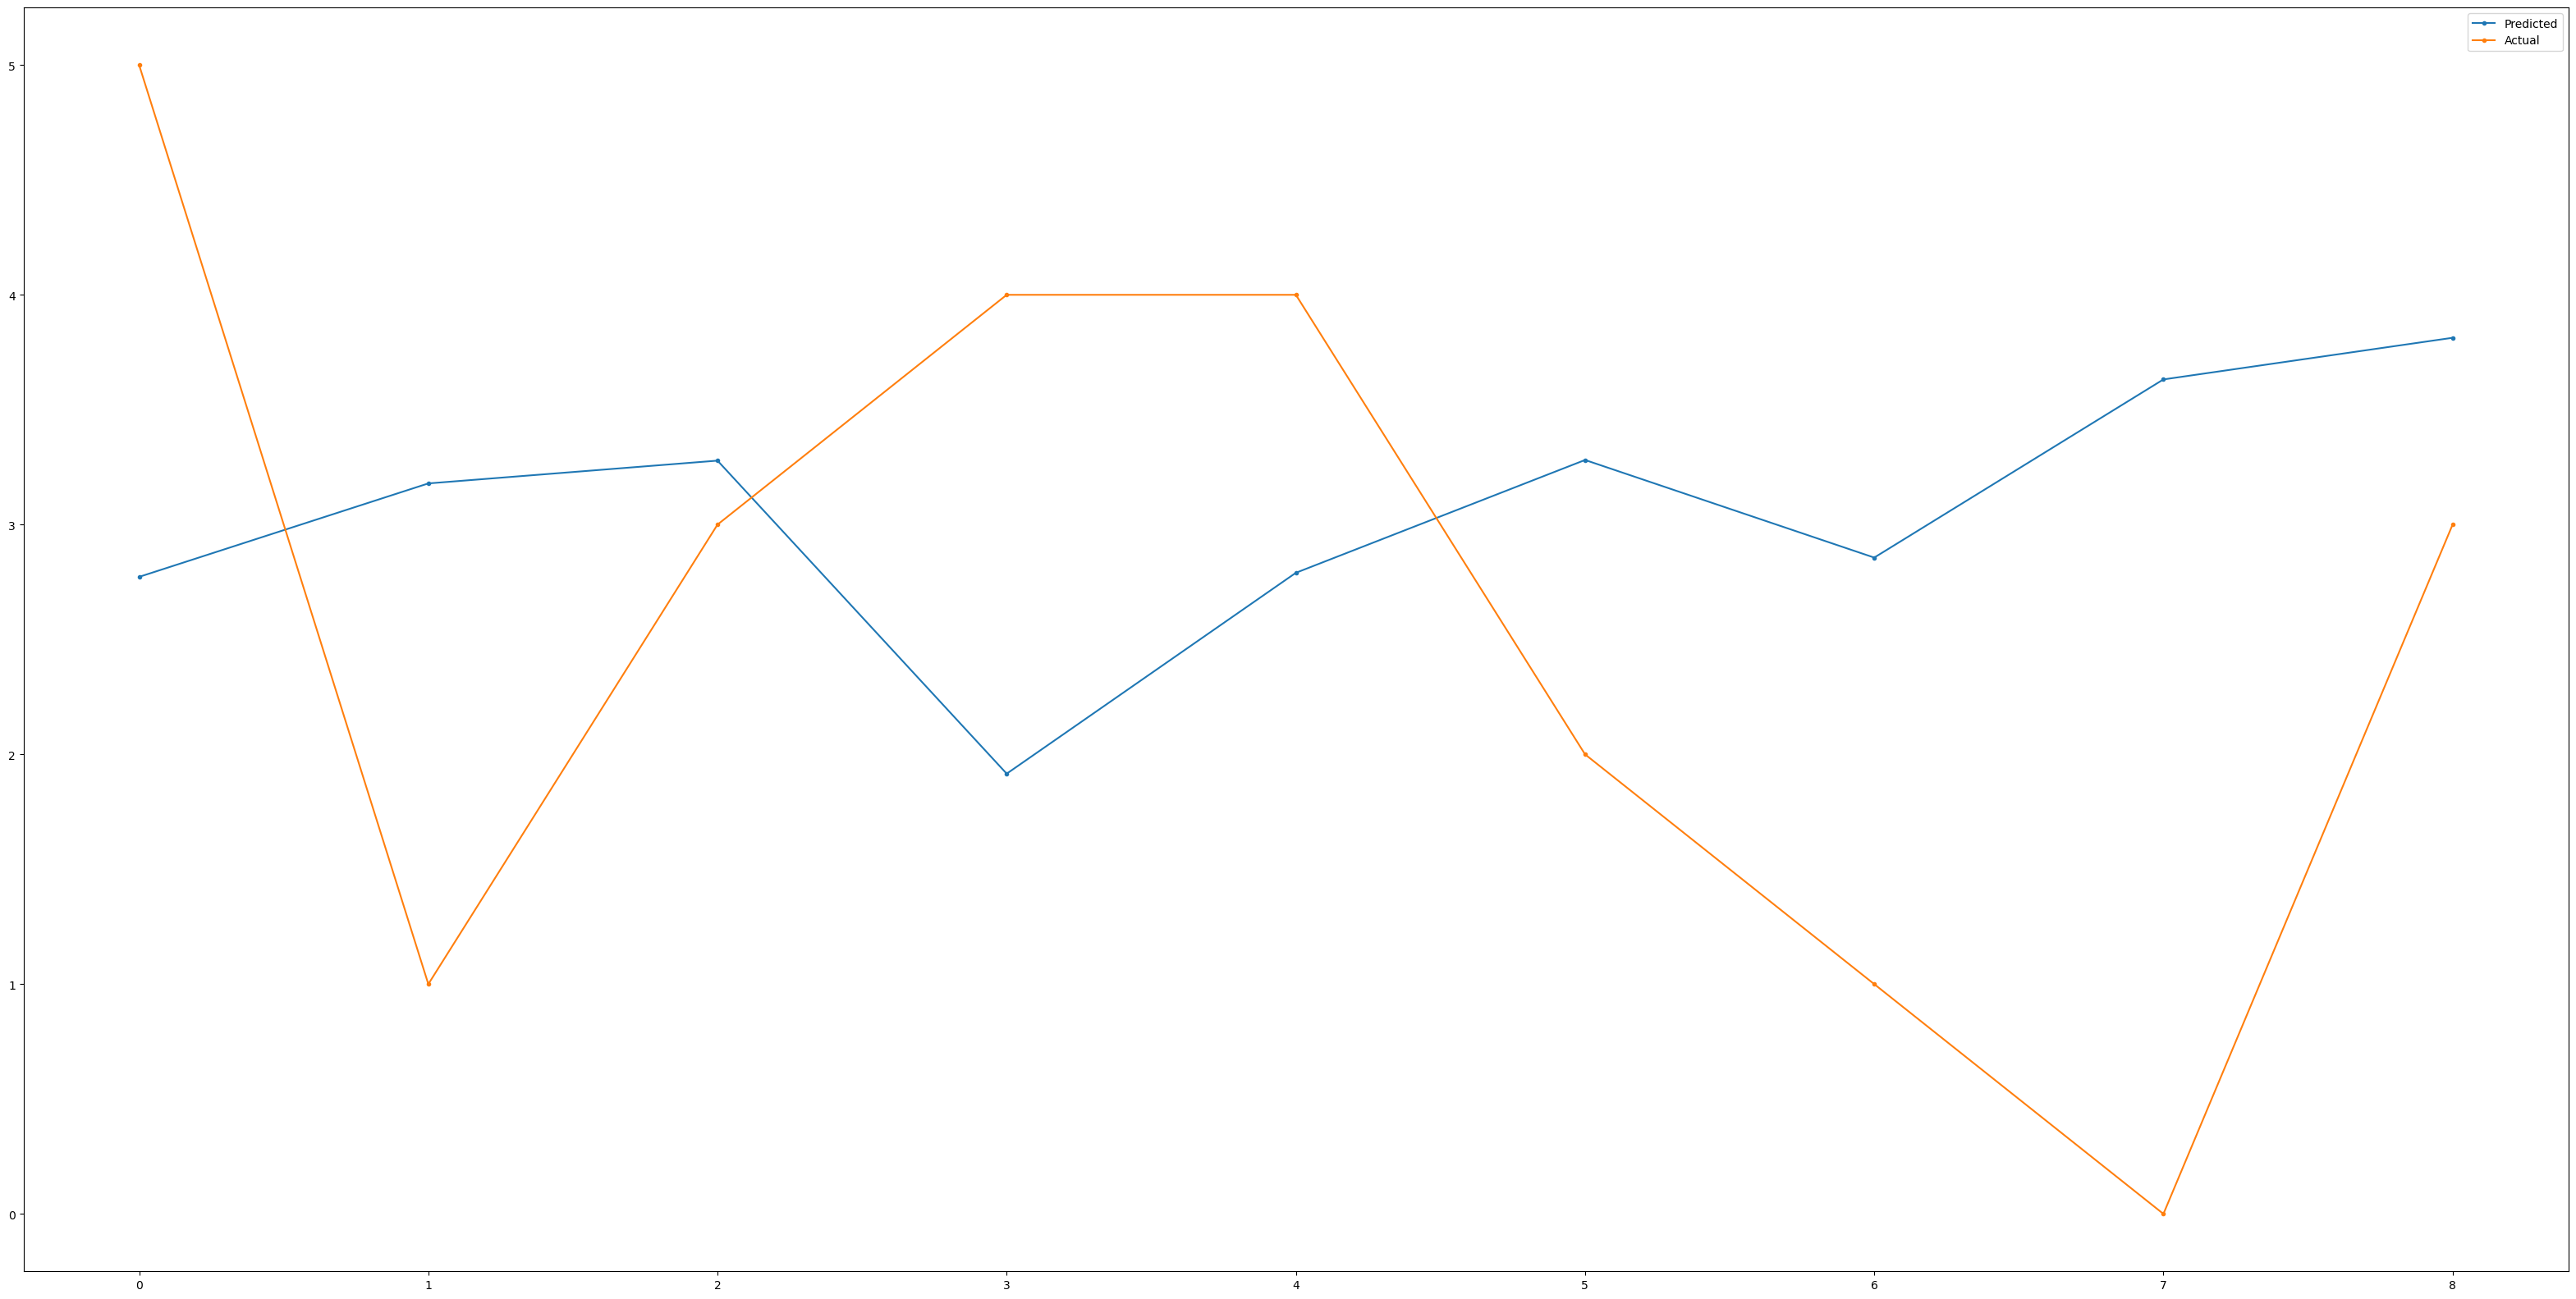

In [517]:
df = pd.DataFrame(list(zip(enc_tar[enc_tar['position_GK']==1]['sv_pred'] , enc_tar[enc_tar['position_GK']==1]['saves'] )),
                #   index = subjects ,
                  columns = [ 'Predicted' , 'Actual' ])

df.plot(style='.-', figsize=(40, 20))

## Red Cards


In [532]:
# - Include Bookmarker odds
# - xG90 last 5 full matches
# - G90 last 5 full matches
# - Position
# - was home
# - FDR
# -----------------------------------------
# - Exclude Gks
# - Start with Gw 6
# - Only those who played 90 minutes are included
#

In [ ]:
#
rc_data= data[(data['minutes_5'] >= 300) & (data['position'] != 'GK')][['position', 'minutes_3', 'minutes_5', 'team_h_difficulty', 'team_a_difficulty', 'was_home', 'ict_index_3',
                                                                         'ict_index_5', 'influence_3', 'influence_5', 'creativity_3', 'creativity_5', 'threat_3', 'threat_5',
                                                                         'red_cards', 'red_cards_3', 'red_cards_5', 'whh', 'whd', 'wha']]

rc_data_tar = data_tar[(data_tar['minutes_5'] >= 300) & (data_tar['position'] != 'GK')][['position', 'minutes_3', 'minutes_5', 'team_h_difficulty', 'team_a_difficulty', 'was_home', 'ict_index_3',
                                                                         'ict_index_5', 'influence_3', 'influence_5', 'creativity_3', 'creativity_5', 'threat_3', 'threat_5',
                                                                         'red_cards', 'red_cards_3', 'red_cards_5', 'whh', 'whd', 'wha']]

# players = data_225 #.drop('position', axis=1) #  & (data['position'] == 'FWD')
# # players


In [534]:
enc =  pd.get_dummies(rc_data, columns=['position', 'was_home'])
enc_tar = pd.get_dummies(rc_data_tar, columns=['position', 'was_home'])
enc_tar_y = enc_tar['red_cards']
enc_tar_X = enc_tar.drop('red_cards', axis=1)

In [535]:

rc = enc[['red_cards']]
feats = enc.drop('red_cards', axis=1)
feats_train, feats_test, rc_train, rc_test = train_test_split(feats, rc , test_size=0.2, random_state=42)

In [536]:
model = LinearRegression()

model.fit(feats_train, rc_train)

pred_train = model.predict(feats_train)
pred_test = model.predict(feats_test)


In [537]:
'rmse: ', mean_squared_error(rc_train, pred_train, squared=False), mean_squared_error(rc_test, pred_test, squared=False), 'mse: ', mean_squared_error(rc_train, pred_train), mean_squared_error(rc_test, pred_test), 'mae: ', mean_absolute_error(rc_train, pred_train), mean_absolute_error(rc_test, pred_test), 'score: ', model.score(feats_train, rc_train), model.score(feats_test, rc_test)

('rmse: ',
 0.06852800588856607,
 0.07527382793298813,
 'mse: ',
 0.004696087591063346,
 0.005666149171685105,
 'mae: ',
 0.009775027940776511,
 0.010855437263668196,
 'score: ',
 0.0025286758502028883,
 -0.004199884581133295)

In [538]:
tree_rmses = -cross_val_score(model, feats_train, rc_train, scoring="neg_root_mean_squared_error", cv=10)
tree_rmses

array([0.03987055, 0.0687484 , 0.00638094, 0.07928713, 0.08842082,
       0.07919798, 0.07926119, 0.05616243, 0.04012343, 0.0970784 ])

In [539]:
pred = model.predict(enc_tar_X)
enc_tar['rc_pred'] = pred

In [540]:
enc_tar.columns #[enc_tar['position']== 'GK']

Index(['minutes_3', 'minutes_5', 'team_h_difficulty', 'team_a_difficulty',
       'ict_index_3', 'ict_index_5', 'influence_3', 'influence_5',
       'creativity_3', 'creativity_5', 'threat_3', 'threat_5', 'red_cards',
       'red_cards_3', 'red_cards_5', 'whh', 'whd', 'wha', 'position_DEF',
       'position_FWD', 'position_MID', 'was_home_False', 'was_home_True',
       'rc_pred'],
      dtype='object')

In [541]:
enc_tar

,minutes_3,minutes_5,team_h_difficulty,team_a_difficulty,ict_index_3,ict_index_5,influence_3,influence_5,creativity_3,creativity_5,...,red_cards_5,whh,whd,wha,position_DEF,position_FWD,position_MID,was_home_False,was_home_True,rc_pred
21,270.0,450.0,2,2,11.4,21.8,60.2,97.2,30.7,83.7,...,0.0,0.47,0.29,0.29,1,0,0,1,0,0.002370
70,224.0,365.0,2,3,15.6,26.4,27.2,57.4,67.7,113.8,...,0.0,0.49,0.27,0.29,0,0,1,0,1,0.008970
81,270.0,450.0,4,3,26.8,35.7,68.4,79.4,53.3,76.0,...,0.0,0.38,0.26,0.40,0,0,1,0,1,-0.000724
92,256.0,436.0,2,3,16.4,36.1,73.4,123.4,52.8,140.9,...,0.0,0.49,0.27,0.29,0,0,1,0,1,0.004131
111,229.0,357.0,2,2,10.3,11.8,48.2,59.0,44.7,46.8,...,0.0,0.47,0.29,0.29,1,0,0,0,1,0.003429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2223,254.0,434.0,2,3,16.4,19.8,70.2,93.6,69.6,77.7,...,0.0,0.49,0.27,0.29,0,0,1,1,0,0.004028
2238,180.0,326.0,4,3,5.4,8.7,47.6,67.4,4.2,15.0,...,0.0,0.38,0.26,0.40,1,0,0,1,0,-0.001203
2249,253.0,433.0,2,2,8.0,20.5,45.6,114.6,16.7,40.8,...,0.0,0.44,0.28,0.32,0,0,1,1,0,0.003657
2285,270.0,450.0,2,2,9.2,14.7,65.6,113.2,16.2,17.7,...,0.0,0.44,0.28,0.32,1,0,0,1,0,0.003123


<Axes: >

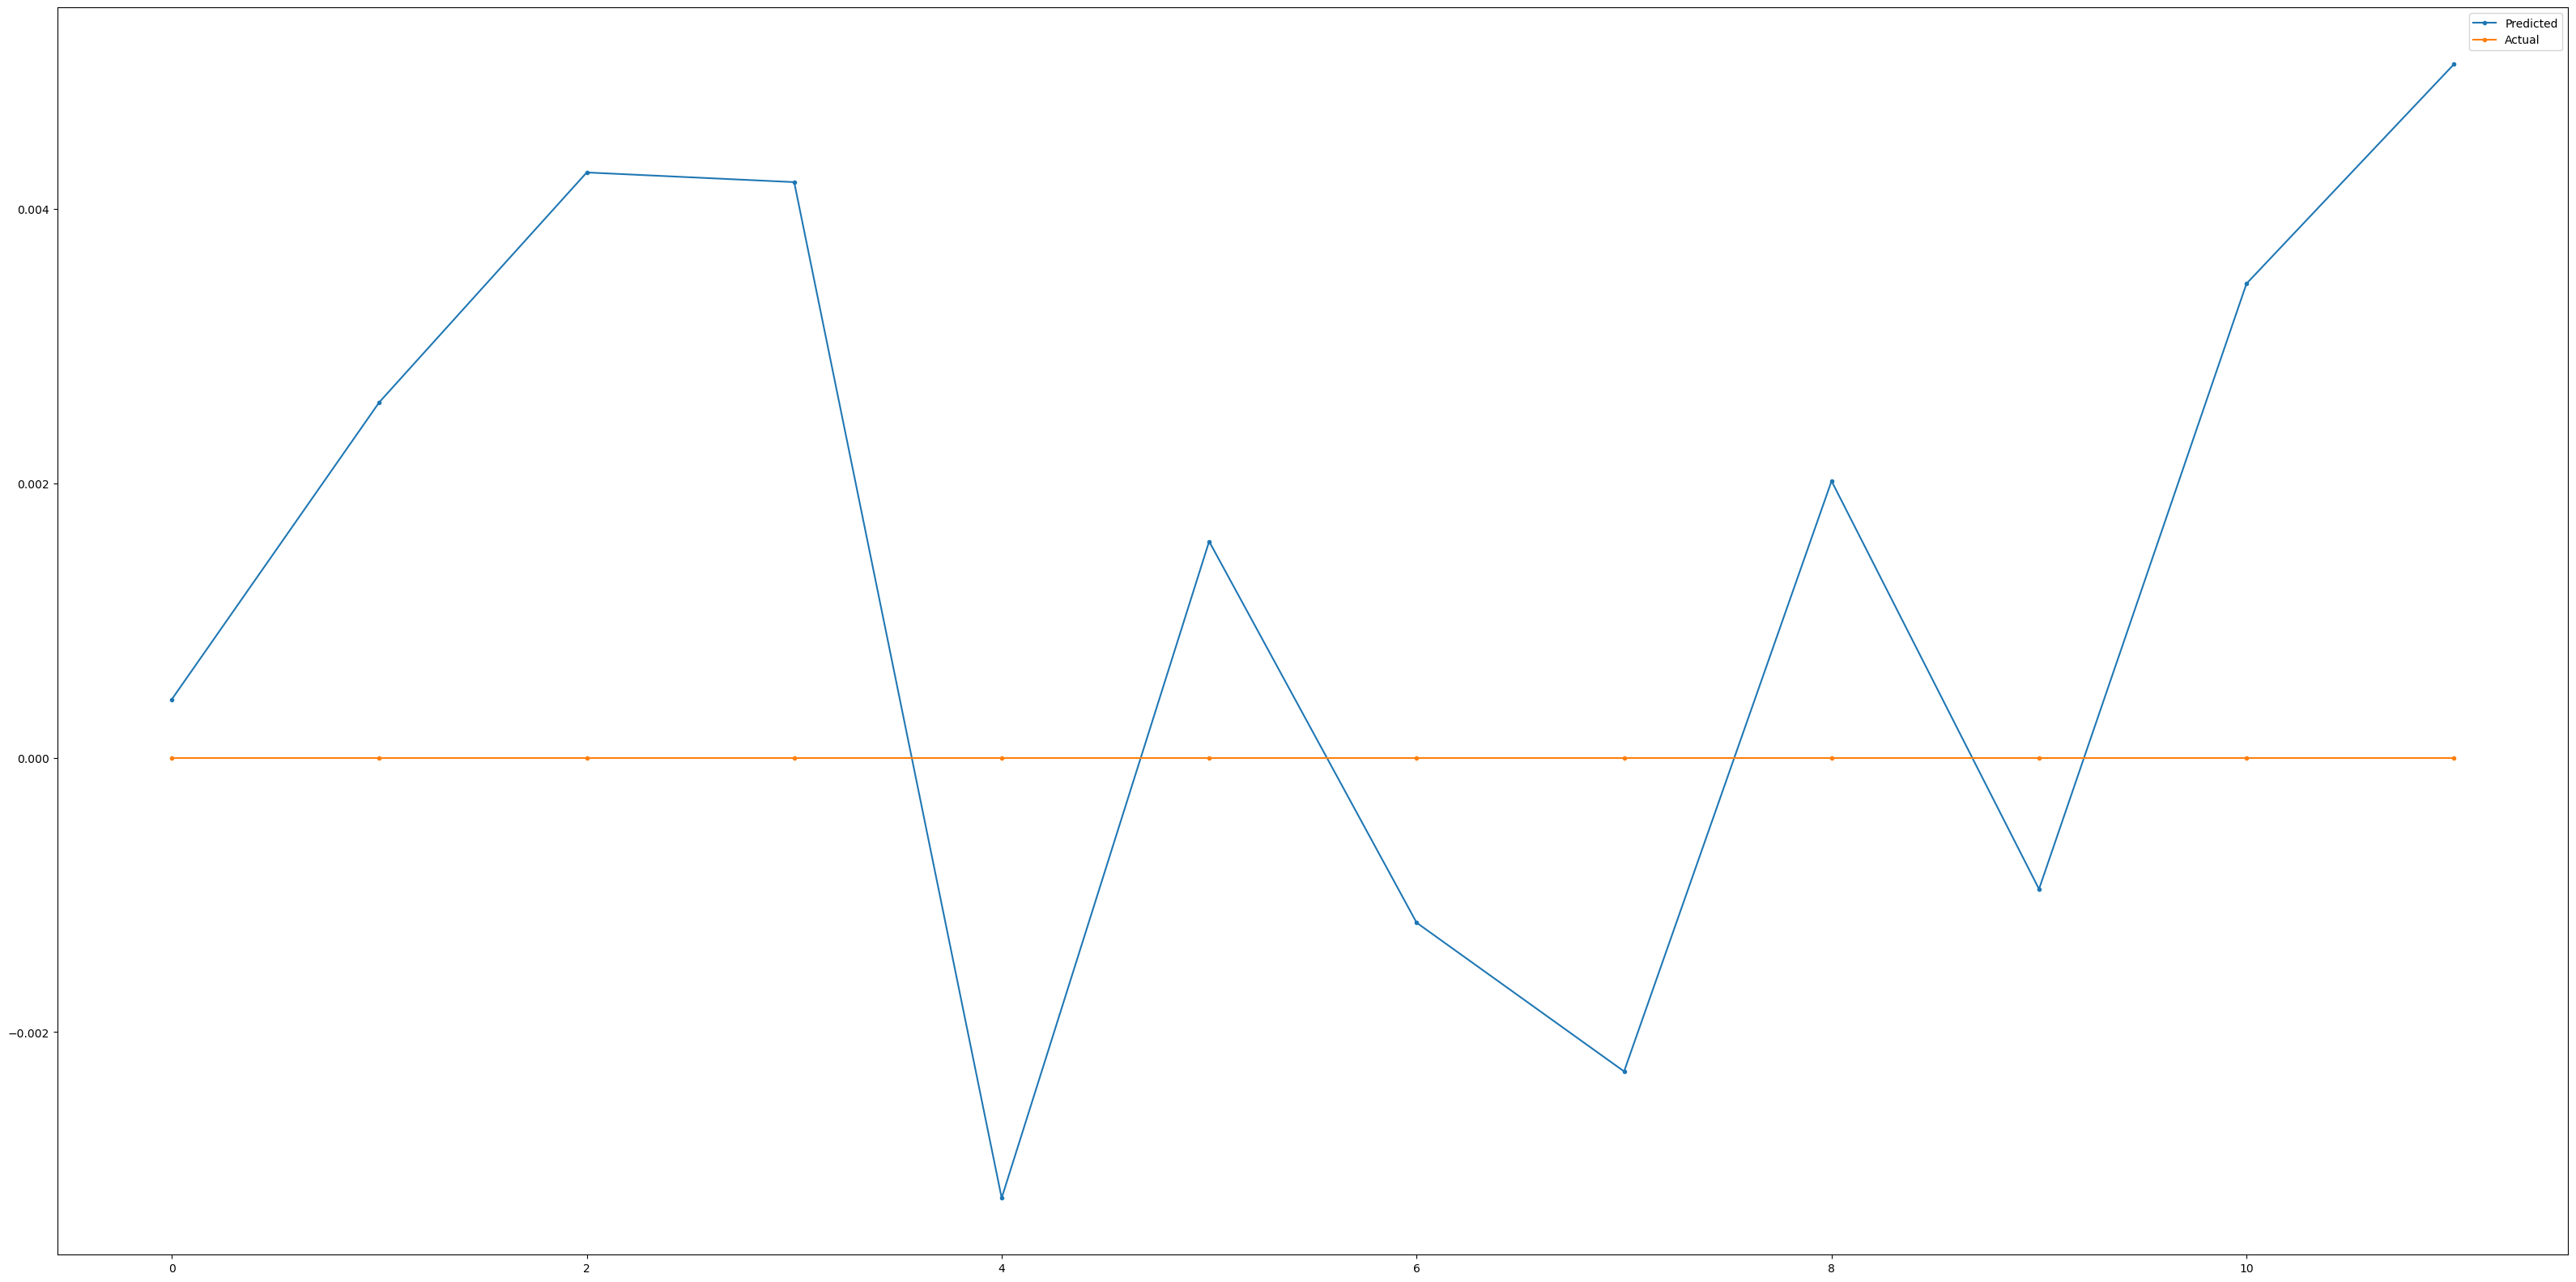

In [545]:
df = pd.DataFrame(list(zip(enc_tar[enc_tar['position_FWD']==1]['rc_pred'] , enc_tar[enc_tar['position_FWD']==1]['red_cards'] )),
                #   index = subjects ,
                  columns = [ 'Predicted' , 'Actual' ])

df.plot(style='.-', figsize=(40, 20))

## Yellow Cards


In [546]:
# - Include Bookmarker odds
# - xG90 last 5 full matches
# - G90 last 5 full matches
# - Position
# - was home
# - FDR
# -----------------------------------------
# - Exclude Gks
# - Start with Gw 6
# - Only those who played 90 minutes are included
#

In [ ]:
#
yc_data= data[(data['minutes_5'] >= 300) & (data['position'] != 'GK')][['position', 'minutes_3', 'minutes_5', 'team_h_difficulty', 'team_a_difficulty', 'was_home', 'ict_index_3',
                                                                         'ict_index_5', 'influence_3', 'influence_5', 'creativity_3', 'creativity_5', 'threat_3', 'threat_5',
                                                                         'yellow_cards', 'yellow_cards_3', 'yellow_cards_5', 'whh', 'whd', 'wha']]

yc_data_tar = data_tar[(data_tar['minutes_5'] >= 300) & (data_tar['position'] != 'GK')][['position', 'minutes_3', 'minutes_5', 'team_h_difficulty', 'team_a_difficulty', 'was_home', 'ict_index_3',
                                                                         'ict_index_5', 'influence_3', 'influence_5', 'creativity_3', 'creativity_5', 'threat_3', 'threat_5',
                                                                         'yellow_cards', 'yellow_cards_3', 'yellow_cards_5', 'whh', 'whd', 'wha']]

# players = data_225 #.drop('position', axis=1) #  & (data['position'] == 'FWD')
# # players


In [548]:
enc =  pd.get_dummies(yc_data, columns=['position', 'was_home'])
enc_tar = pd.get_dummies(yc_data_tar, columns=['position', 'was_home'])
enc_tar_y = enc_tar['yellow_cards']
enc_tar_X = enc_tar.drop('yellow_cards', axis=1)

In [549]:

yc = enc[['yellow_cards']]
feats = enc.drop('yellow_cards', axis=1)
feats_train, feats_test, yc_train, yc_test = train_test_split(feats, yc , test_size=0.2, random_state=42)

In [550]:
model = LinearRegression()

model.fit(feats_train, yc_train)

pred_train = model.predict(feats_train)
pred_test = model.predict(feats_test)


In [551]:
'rmse: ', mean_squared_error(yc_train, pred_train, squared=False), mean_squared_error(yc_test, pred_test, squared=False), 'mse: ', mean_squared_error(yc_train, pred_train), mean_squared_error(yc_test, pred_test), 'mae: ', mean_absolute_error(yc_train, pred_train), mean_absolute_error(yc_test, pred_test), 'score: ', model.score(feats_train, yc_train), model.score(feats_test, yc_test)

('rmse: ',
 0.3612491747123791,
 0.37240457939761296,
 'mse: ',
 0.130500966230375,
 0.138685170756313,
 'mae: ',
 0.26100193246074993,
 0.2690062536998729,
 'score: ',
 0.01180112258663002,
 0.006470369731867098)

In [552]:
tree_rmses = -cross_val_score(model, feats_train, yc_train, scoring="neg_root_mean_squared_error", cv=10)
tree_rmses

array([0.37030704, 0.34725051, 0.37717019, 0.34212558, 0.35981558,
       0.32401204, 0.35393193, 0.37815793, 0.37949171, 0.3871351 ])

In [553]:
pred = model.predict(enc_tar_X)
enc_tar['yc_pred'] = pred

In [554]:
enc_tar.columns #[enc_tar['position']== 'GK']

Index(['minutes_3', 'minutes_5', 'team_h_difficulty', 'team_a_difficulty',
       'ict_index_3', 'ict_index_5', 'influence_3', 'influence_5',
       'creativity_3', 'creativity_5', 'threat_3', 'threat_5', 'yellow_cards',
       'yellow_cards_3', 'yellow_cards_5', 'whh', 'whd', 'wha', 'position_DEF',
       'position_FWD', 'position_MID', 'was_home_False', 'was_home_True',
       'yc_pred'],
      dtype='object')

In [555]:
enc_tar

,minutes_3,minutes_5,team_h_difficulty,team_a_difficulty,ict_index_3,ict_index_5,influence_3,influence_5,creativity_3,creativity_5,...,yellow_cards_5,whh,whd,wha,position_DEF,position_FWD,position_MID,was_home_False,was_home_True,yc_pred
21,270.0,450.0,2,2,11.4,21.8,60.2,97.2,30.7,83.7,...,0.0,0.47,0.29,0.29,1,0,0,1,0,0.146034
70,224.0,365.0,2,3,15.6,26.4,27.2,57.4,67.7,113.8,...,1.0,0.49,0.27,0.29,0,0,1,0,1,0.124543
81,270.0,450.0,4,3,26.8,35.7,68.4,79.4,53.3,76.0,...,1.0,0.38,0.26,0.40,0,0,1,0,1,0.106338
92,256.0,436.0,2,3,16.4,36.1,73.4,123.4,52.8,140.9,...,0.0,0.49,0.27,0.29,0,0,1,0,1,0.120041
111,229.0,357.0,2,2,10.3,11.8,48.2,59.0,44.7,46.8,...,1.0,0.47,0.29,0.29,1,0,0,0,1,0.120993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2223,254.0,434.0,2,3,16.4,19.8,70.2,93.6,69.6,77.7,...,1.0,0.49,0.27,0.29,0,0,1,1,0,0.198813
2238,180.0,326.0,4,3,5.4,8.7,47.6,67.4,4.2,15.0,...,4.0,0.38,0.26,0.40,1,0,0,1,0,0.241683
2249,253.0,433.0,2,2,8.0,20.5,45.6,114.6,16.7,40.8,...,2.0,0.44,0.28,0.32,0,0,1,1,0,0.223678
2285,270.0,450.0,2,2,9.2,14.7,65.6,113.2,16.2,17.7,...,0.0,0.44,0.28,0.32,1,0,0,1,0,0.164311


<Axes: >

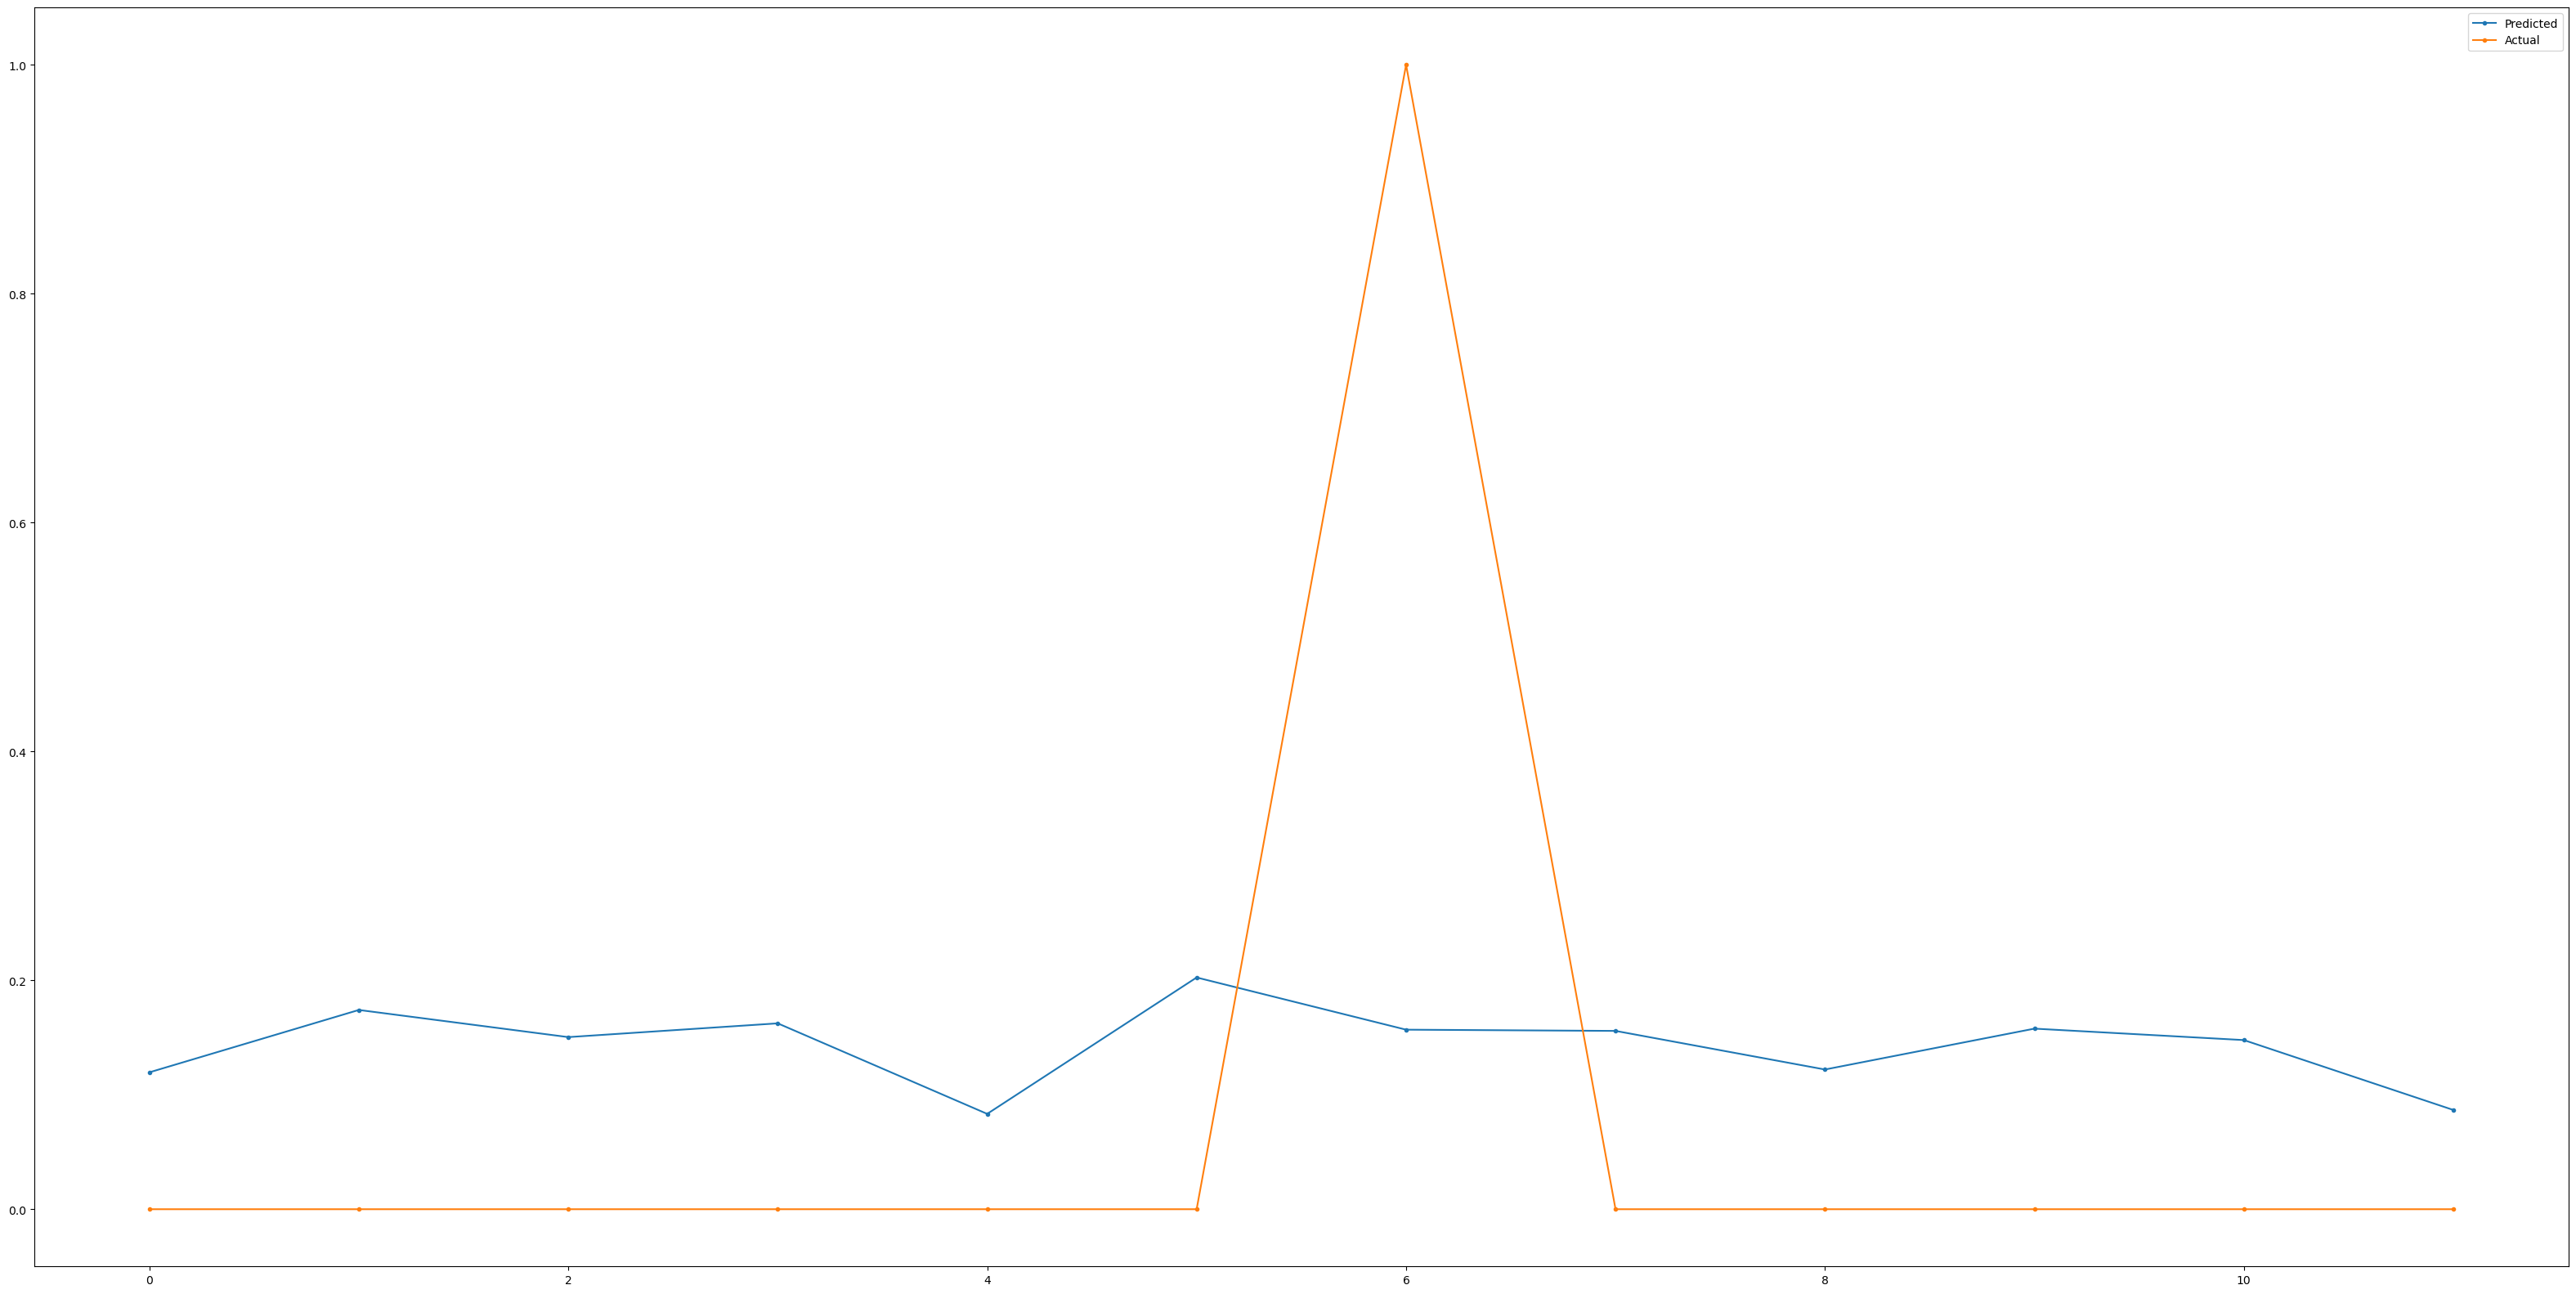

In [556]:
df = pd.DataFrame(list(zip(enc_tar[enc_tar['position_FWD']==1]['yc_pred'] , enc_tar[enc_tar['position_FWD']==1]['yellow_cards'] )),
                #   index = subjects ,
                  columns = [ 'Predicted' , 'Actual' ])

df.plot(style='.-', figsize=(40, 20))